In [123]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 10, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def remove_noise(binary_image):
    ret_val = invert(erode(dilate(dilate(binary_image))))
   
    return ret_val


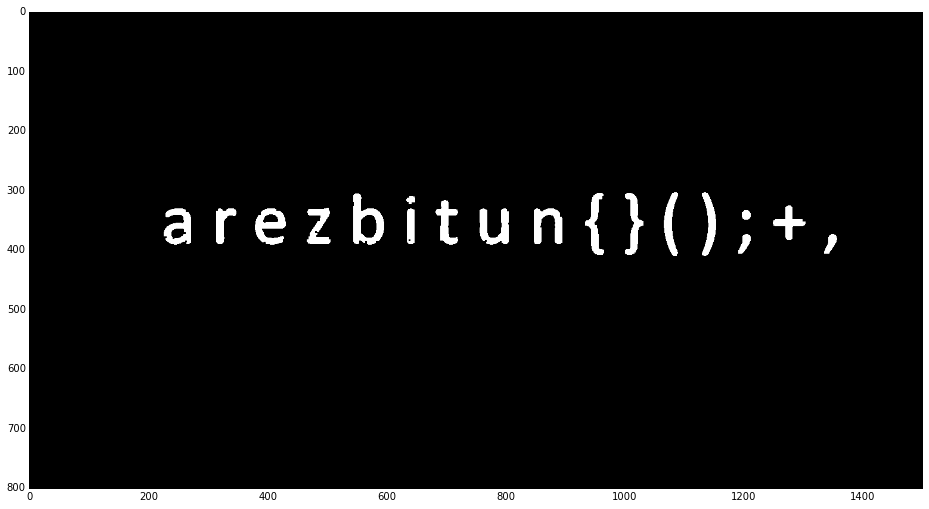

In [124]:
#otklanjanje suma
img_train = load_image('popravni1_train.jpg')
img_train_bin = remove_noise(image_bin(image_gray(img_train)))
display_image(img_train_bin)


In [125]:
# TODO 1 - Rotiranje regiona
def rotate_regions(contours,angles,centers,sizes):
    '''Funkcija koja vrši rotiranje regiona oko njihovih centralnih tačaka
    Args:
        contours: skup svih kontura [kontura1, kontura2, ..., konturaN]
        angles:   skup svih uglova nagiba kontura [nagib1, nagib2, ..., nagibN]
        centers:  skup svih centara minimalnih pravougaonika koji su opisani 
                  oko kontura [centar1, centar2, ..., centarN]
        sizes:    skup parova (height,width) koji predstavljaju duzine stranica minimalnog
                  pravougaonika koji je opisan oko konture [(h1,w1), (h2,w2), ...,(hN,wN)]
    Return:
        ret_val: rotirane konture'''
    ret_val = []
    for idx, contour in enumerate(contours):
                
        angle = angles[idx]
        cx,cy = centers[idx]
        height, width = sizes[idx]
        if width<height:
            angle+=90
            
        # Rotiranje svake tačke regiona oko centra rotacije
        alpha = np.pi/2 - abs(np.radians(angle))
        region_points_rotated = np.ndarray((len(contour), 2), dtype=np.int16)
        for i, point in enumerate(contour):
            x = point[0]
            y = point[1]
            
            #TODO 1 - izračunati koordinate tačke nakon rotacije
            rx = np.sin(alpha)*(x-cx) - np.cos(alpha)*(y-cy) + cx
            ry = np.cos(alpha)*(x-cx) + np.sin(alpha)*(y-cy) + cy
            
            
            region_points_rotated[i] = [rx,ry]
        ret_val.append(region_points_rotated)
        

    return ret_val

In [126]:
# TODO 2
def merge_regions(contours):
    '''Funkcija koja vrši spajanje kukica i kvačica sa osnovnim karakterima
    Args:
        contours: skup svih kontura (kontura - niz tacaka bele boje)
    Return:
        ret_val: skup kontura sa spojenim kukicama i kvacicama'''
    ret_val = []
    merged_index = [] #lista indeksa kontura koje su već spojene sa nekim

    for i,contour1 in enumerate(contours): #slova
        if i in merged_index:
            continue
        min_x1 = min(contour1[:,0])
        max_x1 = max(contour1[:,0])
        min_y1 = min(contour1[:,1])
        max_y1 = max(contour1[:,1])
        for j,contour2 in enumerate(contours): #kukice
            if j in merged_index or i == j:
                continue
            min_x2 = min(contour2[:,0])
            max_x2 = max(contour2[:,0])
            min_y2 = min(contour2[:,1])
            max_y2 = max(contour2[:,1])
            
            #TODO 2 - izvršiti spajanje kukica iznad slova
            #spajanje dva niza je moguće obaviti funkcijom np.concatenate((contour1,contour2))
            
            
                    
                    
            if (max_y2- min_y1)>max_y2-min_y2+max_y1-min_y1:
                ret_val.append(np.concatenate((contour1,contour2)))
                merged_index.append(i)
                merged_index.append(j)
                    
    #svi regioni koji se nisu ni sa kim spojili idu u listu kontura, bez spajanja
    for idx,contour in enumerate(contours):
        if idx not in merged_index:
            ret_val.append(contour)
        
    return ret_val



# TODO 2 - TEST
image_test2_original = load_image('popravni1_train.jpg')
image_test2 = remove_noise(image_bin(image_gray(image_test2_original)))
img2, contours_borders2, hierarchy2 = cv2.findContours(image_test2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
contours2 = []
for contour2 in contours_borders2:
    center, size, angle = cv2.minAreaRect(contour2)
    xt,yt,h,w = cv2.boundingRect(contour2)
    region_points2 = []
    for i in range (xt,xt+h):
        for j in range(yt,yt+w):
            dist = cv2.pointPolygonTest(contour2,(i,j),False)
            if dist>=0 and image_test2[j,i]==255: # da li se tacka nalazi unutar konture?
                region_points2.append([i,j])
    contours2.append(np.asarray(region_points2))
contour_count = merge_regions(contours2)
print "Regions found: ",len(contour_count)
if len(contour_count) == 16:
    print "TODO 2 Test - Passed"
else:
    print "TODO 2 Test - Failed"

Regions found:  16
TODO 2 Test - Passed


In [127]:
# TODO 3
def select_roi(image_orig, image_bin):
    
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours = []
    contour_angles = []
    contour_centers = []
    contour_sizes = []
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,h,w = cv2.boundingRect(contour)

        region_points = []
        for i in range (xt,xt+h):
            for j in range(yt,yt+w):
                dist = cv2.pointPolygonTest(contour,(i,j),False)
                if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                    region_points.append([i,j])
        contour_centers.append(center)
        contour_angles.append(angle)
        contour_sizes.append(size)
        contours.append(region_points)
    
    #Postavljanje kontura u vertikalan polozaj
    contours = rotate_regions(contours, contour_angles, contour_centers, contour_sizes)
    
    #spajanje kukica i kvacica
    contours = merge_regions(contours)
    
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])

        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
             # TODO 3 - koordinate tacaka regiona prebaciti u relativne koordinate
            '''Pretpostavimo da gornja leva tačka regiona ima apsolutne koordinate (100,100).
            Ako uzmemo tačku sa koordinatama unutar regiona, recimo (105,105), nakon
            prebacivanja u relativne koordinate tačka bi trebala imati koorinate (5,5) unutar
            samog regiona.
            '''
            region[y-min_y,x-min_x] = 255

        
        regions_dict[min_x] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    
    return image_orig, sorted_regions[:, 0], region_distances

Broj prepoznatih regiona: 13
800


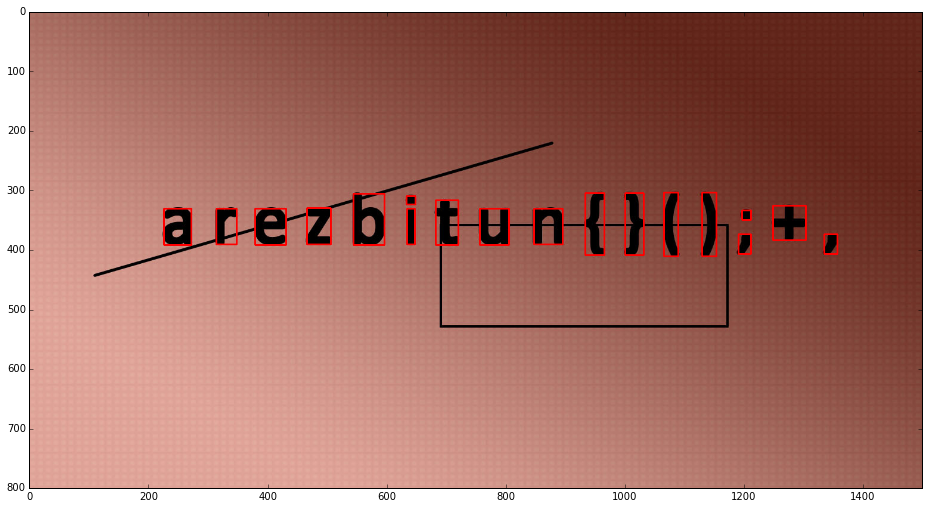

In [128]:
selected_regions, letters, region_distances = select_roi(image_test_original.copy(), image_test)
print 'Broj prepoznatih regiona:', len(letters)
print len(selected_regions)
display_image(img)

In [103]:
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=28 * 28, activation='sigmoid'))
    ann.add(Dense(10, activation='sigmoid'))
    #ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    #ann.add(Activation("sigmoid"))
    #ann.add(Dense(input_dim=128, output_dim=10,init="glorot_uniform"))
    #ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [116]:
image_test_original_obucavanje = load_image('popravni1_train.jpg')
image_test_obucavanje = remove_noise(image_bin(image_gray(image_test_original_obucavanje)))

selected_test_obucavanje, letters_obucavanje, region_distances_obucavanje = select_roi(image_test_original_obucavanje.copy(), image_test_obucavanje)
region_distances_obucavanje = np.array(region_distances_obucavanje).reshape(len(region_distances_obucavanje), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_obucavanje)
inputs_obucavanje = prepare_for_ann(letters_obucavanje)
alphabet = ['a','r','e','z','b','i','t','u','n','{','}','(',')',';','+',',']
outputs_obucavanje = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs_obucavanje, outputs_obucavanje)

ValueError: Input dimension mis-match. (input[0].shape[1] = 10, input[1].shape[1] = 16)
Apply node that caused the error: Elemwise{Sub}[(0, 0)](AdvancedSubtensor1.0, AdvancedSubtensor1.0)
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(1L, 10L), (1L, 16L)]
Inputs strides: [(80L, 8L), (128L, 8L)]
Inputs values: ['not shown', 'not shown']

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [51]:
#   rez(int a,int b){
#     a++;
#     return a+b;
#   }


def display_result(outputs, alphabet):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        if (k_means.labels_[idx] == w_space_group):
            result += ' '
        result += alphabet[winner(output)]
    return result
#    for i in range(0,len(ciphers),3):
#        code = ciphers[i] * 100
#        code += ciphers[i+1] * 10
#        code += ciphers[i+2]
#        codes.append(code)
#    result = ""
#    for code in codes:
#        result += chr(code)
        
  

32
32
['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e']


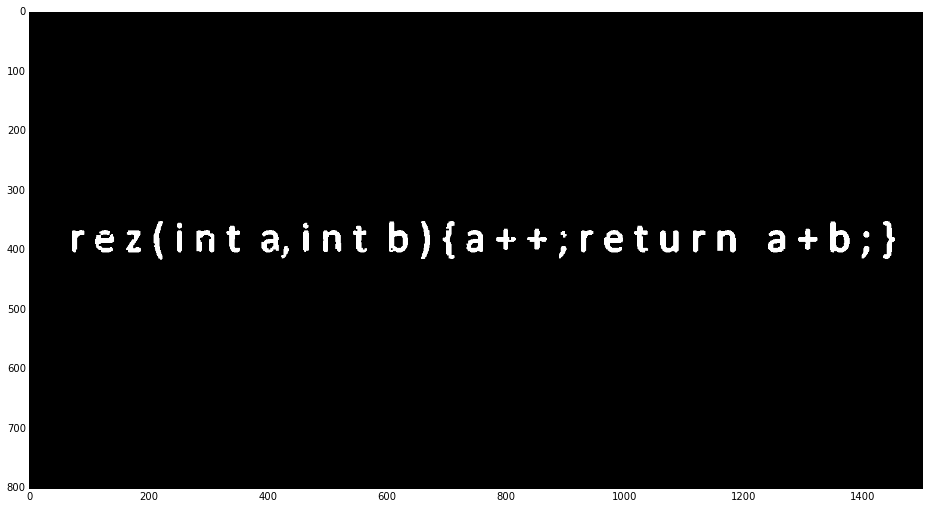

In [52]:
img_test = load_image('popravni1_test.jpg')
img_test_bin = remove_noise(image_bin(image_gray(img_test)))
selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test)
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
display_image(img_test_bin)
sel_img_test, shapes = select_roi(img_test.copy(), img_test_bin)
#display_image(sel_img_test)
print len(shapes)
inputs = prepare_for_ann(shapes)
results = ann.predict(np.array(inputs, np.float32))
print len(results)
print display_result(results, alphabet)